**Part 3 - Looseness prediction**

Paulo Yoshio Kuga

In [4]:
import pandas as pd
import os

import matplotlib.pyplot as plt

from scipy import signal

import scipy.fft as fourier
from scipy.signal.windows import hann

import numpy as np

import re

import ast

*1. Extract features that might be relevant for distinguishing between a healthy and loose asset. Plot the features from the dataset using any data visualization you find relevant.*

First, we load the metadata, and using it, we can load the real data.

In [5]:
path = './part_3/'

metadata = pd.read_csv(path + 'part_3_metadata.csv')

dictChannel = {'Ch1 Y-Axis': 'axisX', 'Ch2 Y-Axis': 'axisY','Ch3 Y-Axis': 'axisZ','X-Axis':"time"}

dataDict = {sample_id: pd.read_csv(path + "data/" + sample_id + ".csv") for sample_id in metadata["sample_id"]}

for i,file in metadata.iterrows():
    data = dataDict[file["sample_id"]]
    data.set_index("X-Axis", inplace=True)
    dictOrientation = ast.literal_eval(file["orientation"])
    data.columns = [dictOrientation[dictChannel[name]] for name in data.columns]

    

In [18]:
def GenerateWelch(data,nperseg = 1024, overlap_factor = 0.75 ):

    nover = int(nperseg*overlap_factor)

    data = data - data.mean()
   

    fs = data.shape[0] / data.index.max() 

    f, Ph = signal.welch(data["horizontal"].to_numpy(), fs=fs, window='flattop', nperseg=nperseg, noverlap=nover, scaling='density',average='median')
    _, Pv = signal.welch(data["vertical"].to_numpy(), fs=fs, window='flattop', nperseg=nperseg, noverlap=nover, scaling='density',average='median')
    _, Pa = signal.welch(data["axial"].to_numpy(), fs=fs, window='flattop', nperseg=nperseg, noverlap=nover, scaling='density',average='median')

    return f, Ph, Pv, Pa

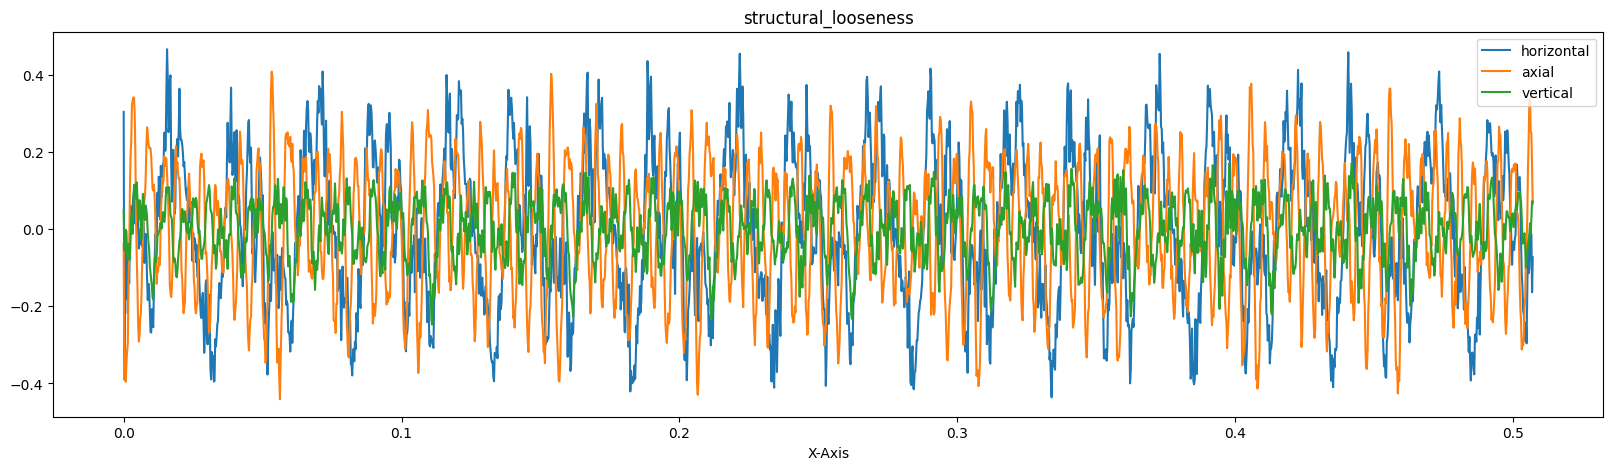

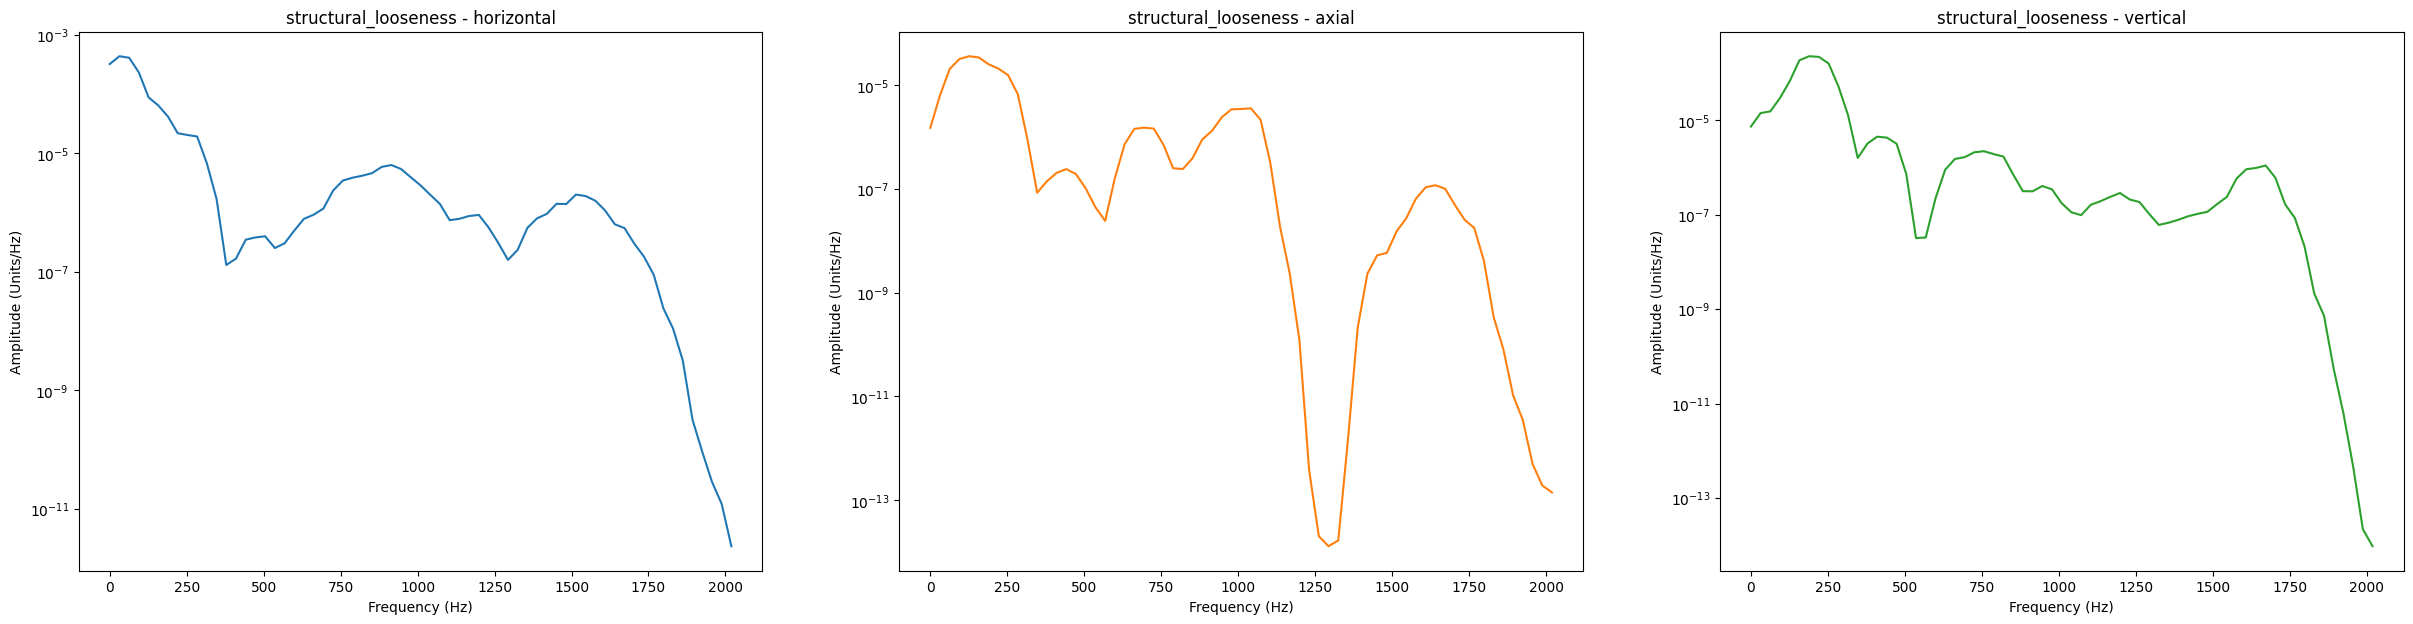

In [138]:
i = 3
w = 128
data = dataDict[metadata["sample_id"][i]]

data.plot(figsize=(20,5))
plt.title(metadata["condition"][i])

f,Ph, Pv, Pa  = GenerateWelch(data,nperseg=w)
P_g = np.array([Ph, Pv, Pa])
fig, axs = plt.subplots(1, 3, figsize=(30, 7))
for j, ax in enumerate(axs):
    ax.semilogy(f, P_g[j], color='C'+str(j))
    ax.set_title(metadata["condition"][i] + " - " + data.columns[j])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude (Units/Hz)')

In [206]:
numbers = (w//2+1)

Mean = np.zeros(numbers*3)
Var = np.zeros(numbers*3)

columnsNames = [f"horizontal_{i}" for i in range(0,numbers)] + [f"vertical_{i}" for i in range(0,numbers)] + [f"axial_{i}" for i in range(0,numbers)]

Z_Dataset = pd.DataFrame(
    index = range(0,len(dataDict)),
    columns=columnsNames
    )

for i,file in metadata.iterrows():
    f,Ph, Pv, Pa  = GenerateWelch(dataDict[file["sample_id"]],nperseg=w)
    Base = np.log10(np.concatenate([Ph,Pv,Pa]))

    Z_Dataset.iloc[i,:] = Base

    Mean += Base
    Var += np.pow(Base,2)

    

Mean = Mean/len(metadata)
Var = Var - np.pow(Mean,2)

Std = np.sqrt(Var)

Z_Dataset = (Z_Dataset)

# for i,file in metadata.iterrows():


    

    

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline

X = Z_Dataset
y = metadata["condition"]

# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# Pipeline: Normalização + Logistic Regression
pipe = Pipeline([
    #('scaler', StandardScaler()),  
    # ('clf', LogisticRegression(
    #     penalty='l2',      # regularização L2 (ridge)
    #     C=0.1,             # inverso da força da regularização
    #     solver='lbfgs',    # eficiente para muitas features
    #     max_iter=500,       # aumenta iterações p/ convergir
    #     class_weight='balanced'
    # ))
    ('clf', SGDClassifier(
        penalty="elasticnet",
        max_iter=700,
        class_weight="balanced",
        
    ))
])

# Treinamento
pipe.fit(X_train, y_train)

# Acurácia em treino e teste
print("Acurácia treino:", pipe.score(X_train, y_train))
print("Acurácia teste :", pipe.score(X_test, y_test))

# Cross-validation (mais robusto)
scores = cross_val_score(pipe, X, y, cv=5)
print("CV mean accuracy:", scores.mean())


Acurácia treino: 1.0
Acurácia teste : 1.0
CV mean accuracy: 0.9960000000000001


In [13]:
from pydantic import BaseModel, Field
from typing import List
class Wave(BaseModel):
    time: List[float] = Field(..., description="Time points of the wave")
    signal: List[float] = Field(..., description="Signal values")
class LoosenessModel:
    def __init__(self, **params):
        # Store hyperparameters if needed
        self.params = params
    def predict(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave) -> bool:
        """
        Predicts the presence of structural looseness based on horizontal,
        vertical, and axial wave data.
        Args:
        wave_hor (Wave): Horizontal wave data
        wave_ver (Wave): Vertical wave data
        wave_axi (Wave): Axial wave data
        Returns:
        bool: True if looseness is detected, False otherwise
        """
        raise NotImplementedError("The 'predict' method must be implemented.")
    def score(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave) -> float:
        """
        Computes a confidence score (between 0 and 1) representing the
        likelihood of structural looseness. This is optional.
        Args:
        wave_hor (Wave): Horizontal wave data
        wave_ver (Wave): Vertical wave data
        wave_axi (Wave): Axial wave data
        Returns:
        float: score (0 = no looseness, 1 = high confidence of looseness)
        """
        raise NotImplementedError("The 'score' method must be implemented.")